Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
from keras.utils import to_categorical

Loading the Dataset to the colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset=os.listdir('/content/drive/MyDrive/Data/train')
test_dataset=os.listdir('/content/drive/MyDrive/Data/test')
valid_dataset=os.listdir('/content/drive/MyDrive/Data/valid')
train_dataset_path="/content/drive/MyDrive/Data/train"
test_dataset_path="/content/drive/MyDrive/Data/test"
valid_dataset_path="/content/drive/MyDrive/Data/valid"

In [ ]:
print(train_dataset)

['squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'normal', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib']


In [ ]:
print(test_dataset)
test_classes= test_dataset

['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']


Preprocessing the images using ImageDataGenerator from keras

In [ ]:
input_shape = (224,224,3)
num_classes = 4

trainGenertor = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    # vertical_flip = True,
    dtype = 'float32'
)

valGenertor = ImageDataGenerator(
    rescale = 1./255,
    dtype='float32'
)

testGenertor = ImageDataGenerator(
    rescale = 1./255,
    dtype='float32'
)

In [ ]:
train_data = trainGenertor.flow_from_directory(
    train_dataset_path,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle= True
)

val_data = valGenertor.flow_from_directory(
    valid_dataset_path,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

test_data = testGenertor.flow_from_directory(
    test_dataset_path,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 713 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 215 images belonging to 4 classes.


Importing the VGG16 model

In [ ]:
VGG16_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)
for layer in VGG16_model.layers :
  layer.trainable = False

Building the CNN model using VGG16 base model

In [ ]:
from keras.src.metrics.confusion_metrics import activations


model = Sequential([
    VGG16_model,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(4, activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 512)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 3, 3, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)             

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
opt=tf.keras.optimizers.Adam(learning_rate = 0.001)
#compiling the model with the parameters
model.compile(
    optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy']
)

Fitting the model with the training and validation dataset

In [ ]:
epochs = 100

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    verbose=1,
)


Epoch 1/100
23/23 [==============================] - 320s 13s/step - loss: 2.0236 - accuracy: 0.3969 - val_loss: 1.1662 - val_accuracy: 0.4028
Epoch 2/100
23/23 [==============================] - 14s 628ms/step - loss: 1.1554 - accuracy: 0.5189 - val_loss: 1.0978 - val_accuracy: 0.4722
Epoch 3/100
23/23 [==============================] - 14s 628ms/step - loss: 1.0651 - accuracy: 0.5217 - val_loss: 1.1288 - val_accuracy: 0.4583
Epoch 4/100
23/23 [==============================] - 14s 626ms/step - loss: 0.9835 - accuracy: 0.5694 - val_loss: 1.0859 - val_accuracy: 0.4583
Epoch 5/100
23/23 [==============================] - 16s 700ms/step - loss: 0.9035 - accuracy: 0.5947 - val_loss: 0.9702 - val_accuracy: 0.5694
Epoch 6/100
23/23 [==============================] - 14s 624ms/step - loss: 0.8378 - accuracy: 0.6297 - val_loss: 0.9554 - val_accuracy: 0.5556
Epoch 7/100
23/23 [==============================] - 14s 621ms/step - loss: 0.7893 - accuracy: 0.6746 - val_loss: 0.9272 - val_accuracy: 

Results

In [ ]:
test = test_data
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

7/7 [==============================] - 74s 12s/step - loss: 0.3451 - accuracy: 0.9349
Test loss: 0.3450644612312317
Test accuracy: 0.934883713722229


In [ ]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
# print(true_label)
report = classification_report(true_label,predictions)
print(report)
# print(predictions)

7/7 [==============================] - 2s 229ms/step
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        80
           1       0.91      0.97      0.94        31
           2       1.00      0.98      0.99        44
           3       1.00      0.83      0.91        60

    accuracy                           0.93       215
   macro avg       0.95      0.94      0.94       215
weighted avg       0.94      0.93      0.93       215



Visualising the results

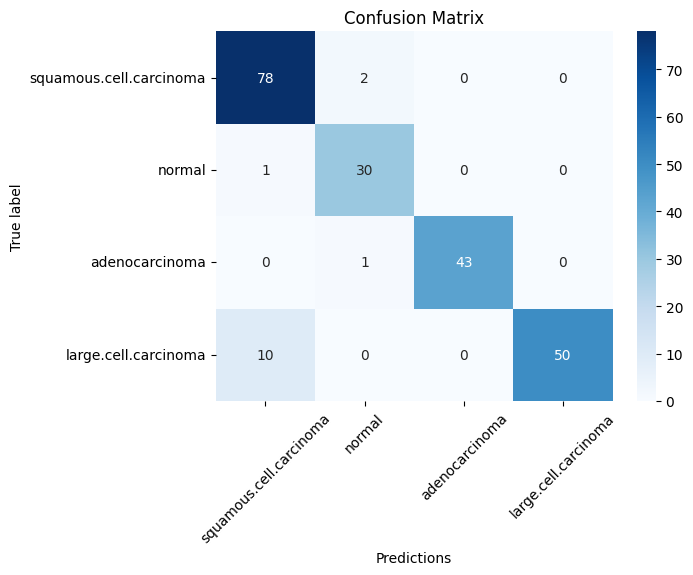

In [ ]:
#confusion matrix
conf_mat = confusion_matrix(true_label,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()

Plotting the results

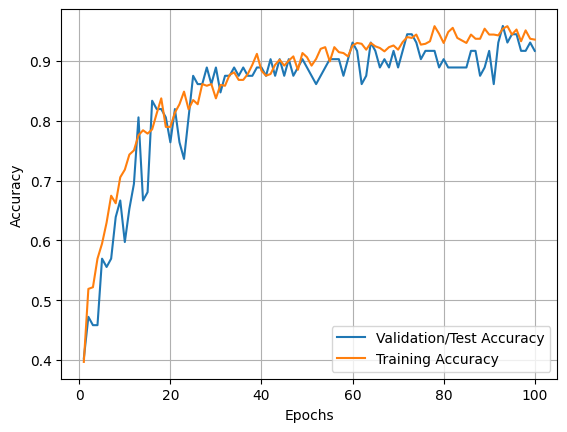

In [ ]:
# print(history.history)
res = history.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, val_accuracy, label = 'Validation/Test Accuracy')
plt.plot(epochs, train_acc, label = 'Training Accuracy')

# plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
# plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

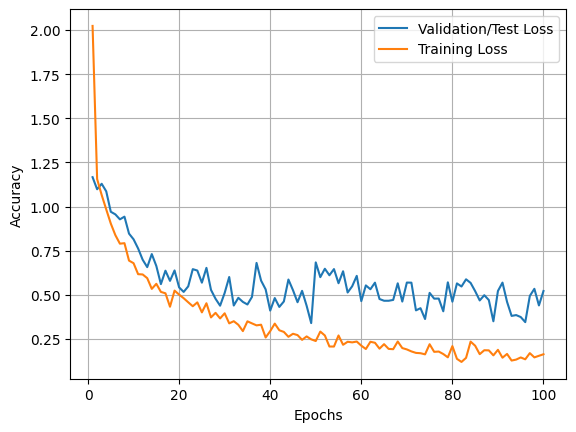

In [ ]:

res = history.history
train_loss = res['loss']
val_loss = res['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, val_loss, label = 'Validation/Test Loss')
plt.plot(epochs, train_loss, label = 'Training Loss')

# plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
# plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
xtest_path=[]
for path in test_dataset:
  p= os.path.join(test_dataset_path,path)
  for i in os.listdir(p):
    pt = os.path.join(p+"/"+i)
    xtest_path.append(pt)


In [ ]:
print(test_data.classes)
print(test_classes)
#adenocarcinoma - 0
#large cell carcinoma -1
#normal -2
#squamous cell carcinoma -3

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']


7/7 [==============================] - 3s 465ms/step


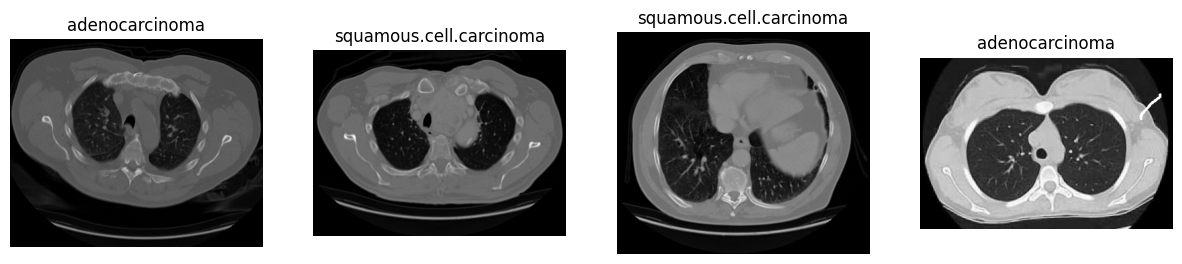

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2



xtest_path=[]
ytest_label=[]
testlabel={'normal':2, 'squamous.cell.carcinoma':3, 'adenocarcinoma':0, 'large.cell.carcinoma':1}
test_classes={2:'normal', 3:'squamous.cell.carcinoma', 0:'adenocarcinoma', 1:'large.cell.carcinoma'}
for path in test_dataset:
  c=path
  p= os.path.join(test_dataset_path,path)
  for i in os.listdir(p):
    pt = os.path.join(p+"/"+i)
    im=cv2.imread(pt)
    xtest_path.append(im)
    ytest_label.append(testlabel[c])


plt.figure(figsize=(15,15))
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
# print(predictions)
c=141
for i in range(4):
  r=random.randint(0,len(xtest_path)-1)
  plt.subplot(c),plt.imshow(xtest_path[r]),plt.title(test_classes[predictions[r]])
  plt.axis('off')
  c+=1


plt.show()


